# Week 9 Workshop

We are continuing to work with the protein language model ESM-2. The model family is available on HuggingFace: https://huggingface.co/facebook/esm2_t12_35M_UR50D

We can access and use the model easily using the `transformers` library: https://huggingface.co/docs/transformers/en/index

As always, we begin by importing the required dependencies.

In [1]:
import torch
from tqdm import tqdm
import pandas as pd
import polars as pl
import plotnine as pln
import torch.nn.functional as F
from transformers import AutoTokenizer, EsmForMaskedLM

Next we're loading the tokenizer and model.

**Note:** If the following code runs extremely slowly or errors out you may have to update your python installation. Alternatively, you can try to run it in a python console, not in Jupyter. Older versions of Jupyter have a bug that prevents this code from running correctly.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
model = EsmForMaskedLM.from_pretrained("facebook/esm2_t12_35M_UR50D")
model.to(device)

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features=480, out_fe

## Helper functions

We will make zero-shot predictions. This requires masking sites and calculating probabilities for them. To do this, we first we define some helper functions to generate masked sequences.

In [3]:
def mask_all_sites(wt_sequence):
    """Take a wild-type protein sequence and separately mask every position of it."""
    masked_sequences = []
    for aa in range(0, len(wt_sequence)):
        mutated_seq = wt_sequence[:aa] + '<mask>' + wt_sequence[aa+1:]
        masked_sequences.append(mutated_seq)
    return masked_sequences

def mask_and_tokenize(tokenizer, wt_sequence):
    """Create masked sites and tokenize them."""
    masked_sequences = mask_all_sites(wt_sequence)
    inputs = tokenizer(masked_sequences, padding=True, return_tensors="pt")
    return inputs

def batch_loader(data, batch_size):
    """Yield successive n-sized chunks of the data.
    This will speed up processing masked sequences, as they
    are processed in batches."""
    for i in range(0, data['input_ids'].size(0), batch_size):
        yield data[i:i + batch_size]

## Zero-shot predictions of β-lactamase data

We'll be working with β-lactamase just like in the previous week. For zero-shot predictions we need the wild-type sequence.

In [4]:
# beta lactamase wt sequence
wt_sequence = 'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW'
len(wt_sequence)

286

Next we generate model inputs, by masking every site in turn and tokenizing the resulting sequences.

In [5]:
inputs = mask_and_tokenize(tokenizer, wt_sequence)
inputs

{'input_ids': tensor([[ 0, 32,  8,  ..., 21, 22,  2],
        [ 0, 20, 32,  ..., 21, 22,  2],
        [ 0, 20,  8,  ..., 21, 22,  2],
        ...,
        [ 0, 20,  8,  ..., 21, 22,  2],
        [ 0, 20,  8,  ..., 32, 22,  2],
        [ 0, 20,  8,  ..., 21, 32,  2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

The tokenized sequences are stored under the `'input_ids'` key in the `inputs` dictionary. There are 286 sequences, one for each site we have masked.

In [6]:
inputs['input_ids'].shape[0]

286

Now we calculate the probabilities, in batches of 4. (This batch size is very conservative. Other sizes may work. On my Macbook Air, 32 works fine.)

In [7]:
batch_size = 4
all_probabilities = {}

for batch_input in tqdm( # iterate using a nice progress bar
        batch_loader(inputs, batch_size), 
        desc = "Processing sequences", 
        leave = False,
        total = inputs['input_ids'].shape[0] // batch_size
    ):

    # Remember, batch_input is a dictionary with two keys,
    # "input_ids" (the actual tokens) and "attention_mask".
    batch_input = {key: val.to(device) for key, val in batch_input.items()}

    with torch.no_grad():
        logits = model(**batch_input).logits

        # Find mask positions
        mask_positions = (batch_input['input_ids'] == tokenizer.mask_token_id).nonzero()
        # Here, use of `nonzero()` assumes exactly one mask per sequence.
        # It returns a tensor of shape [num_matches, num_dimensions]
        # Example for 2D input:
        # tensor([[0, 5],    # batch 0, position 5
        #         [1, 3],    # batch 1, position 3
        #         [2, 7]])   # batch 2, position 7
        # batch_idx = mask_positions[:, 0]  # [0, 1, 2]
        # token_idx = mask_positions[:, 1]  # [5, 3, 7]

        # Extract and softmax the masked logits
        masked_logits = logits[mask_positions[:, 0], mask_positions[:, 1]]
        softmax_logits = F.softmax(masked_logits, dim=-1)

        # Update dictionary
        all_probabilities.update({
            int(idx): probs.tolist() 
            for idx, probs in zip(mask_positions[:, 1].cpu(), softmax_logits.cpu())
        })

# the first index is the site (here, site 1), the second index is the token (i.e., amino acid)
all_probabilities[1][:10]

[1.2575151231430937e-07,
 6.087902404416923e-10,
 5.985946849307311e-09,
 5.992775164997965e-10,
 1.9677272575790994e-05,
 1.4225968698156066e-05,
 5.320451236912049e-06,
 3.580540942493826e-05,
 1.0020958143286407e-05,
 2.437423290757579e-06]

We get 33 probabilities at each size because ESM-2 has a few additional tokens for non-standard amino acids. This will become important when we're processing the data.

In [8]:
len(all_probabilities[1])

33

Let's convert the probabilities into a data frame that is more useful.

In [9]:
# List of tokens of interest/standard AA
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

# Get indices of amino acids in tokenizer.all_tokens
aa_indices = [tokenizer.all_tokens.index(aa) for aa in amino_acids]

aa_indices

[5, 23, 13, 9, 18, 6, 21, 12, 15, 4, 20, 17, 14, 16, 10, 8, 11, 7, 22, 19]

In [10]:
data = [
    {"Site": site, "Amino Acid": aa, "probs": all_probabilities[site][idx]}
    for site in all_probabilities.keys()
    for aa, idx in zip(amino_acids, aa_indices)
]

df_long = pl.DataFrame(data).sort(["Site", "Amino Acid"])
df_long

Site,Amino Acid,probs
i64,str,f64
1,"""A""",0.000014
1,"""C""",0.000004
1,"""D""",0.000002
1,"""E""",0.000002
1,"""F""",0.000014
…,…,…
286,"""S""",0.026863
286,"""T""",0.007702
286,"""V""",0.011208


## Analyzing the zero-shot data

We can make a heatmap of the probabilities at each site.

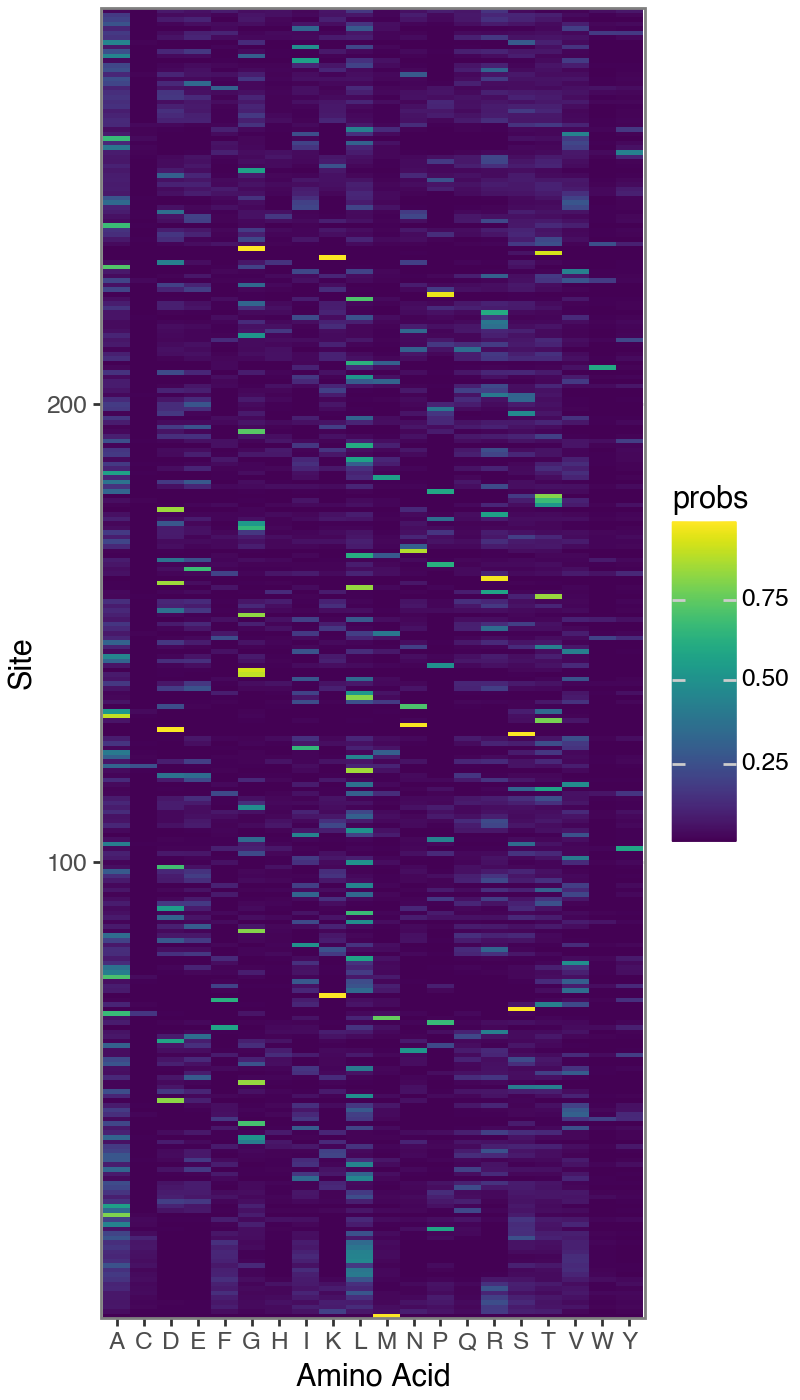

In [11]:
heatmap = (
    pln.ggplot(df_long, pln.aes(x="Amino Acid", y="Site", fill="probs"))
    + pln.geom_tile()
    + pln.scale_y_continuous(expand = (0, 0))
    + pln.theme_bw()
    + pln.theme(
        figure_size = (4, 7)
    )
)
heatmap.show()

We can also identify the amino acid predicted to be the most likely at each site.

In [12]:
# getting the most likely aa predicted at each site
ml_aa = df_long.filter(
    pl.col('probs') == pl.col('probs').max().over('Site')
)
ml_aa

Site,Amino Acid,probs
i64,str,f64
1,"""M""",0.999819
2,"""K""",0.190625
3,"""R""",0.168463
4,"""R""",0.230573
5,"""R""",0.186057
…,…,…
282,"""I""",0.327536
283,"""A""",0.256095
284,"""A""",0.196595


Let's also plot the distribution of probabilities for the predicted best amino acids. (These probabilities can be interpreted as model confidence.)

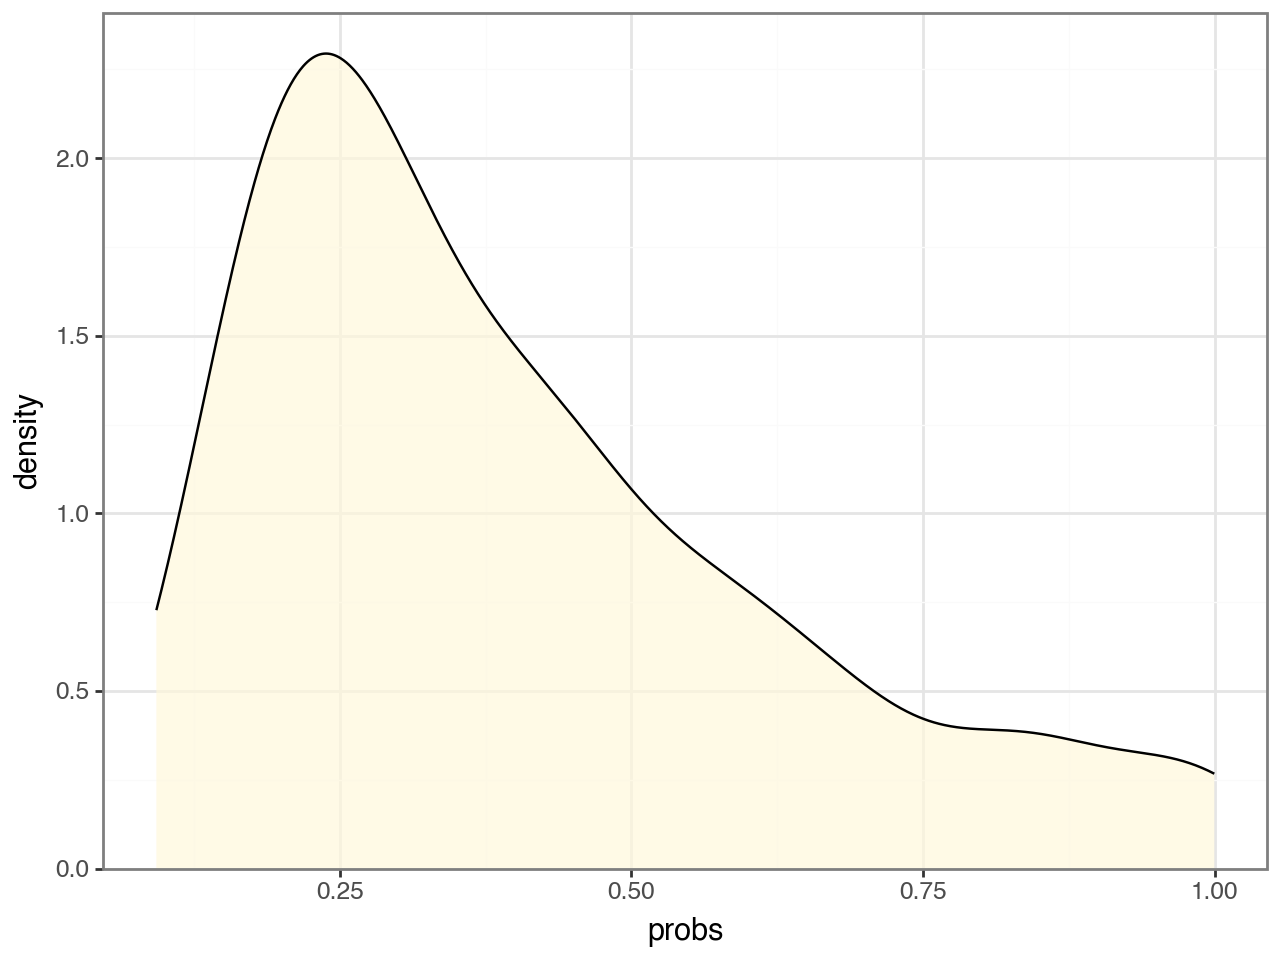

In [13]:
conf_plot = (
    pln.ggplot(ml_aa, pln.aes(x="probs"))
    + pln.geom_density(fill = "cornsilk", alpha = 0.7)
    + pln.scale_y_continuous(expand = (0, 0, 0.05, 0))
    + pln.theme_bw()
    + pln.theme(
#        figure_size = (4, 7)
    )
)
conf_plot.show()

Now we compare the predictions to the experimental β-lactamase data. 

In [14]:
data = pl.read_csv('./data/B-Lactamase_Ranganathan2015.csv')
data.head(5)

ID,mutant,target,sequence,wt,site,mut
str,str,f64,str,str,i64,str
"""BLAT_Ran_H24C""","""H24C""",-0.41826,"""MSIQHFRVALIPFFAAFCLPVFACPETLVK…","""H""",24,"""C"""
"""BLAT_Ran_H24E""","""H24E""",-0.279024,"""MSIQHFRVALIPFFAAFCLPVFAEPETLVK…","""H""",24,"""E"""
"""BLAT_Ran_H24D""","""H24D""",-0.181607,"""MSIQHFRVALIPFFAAFCLPVFADPETLVK…","""H""",24,"""D"""
"""BLAT_Ran_H24G""","""H24G""",-0.060242,"""MSIQHFRVALIPFFAAFCLPVFAGPETLVK…","""H""",24,"""G"""
"""BLAT_Ran_H24F""","""H24F""",-0.818487,"""MSIQHFRVALIPFFAAFCLPVFAFPETLVK…","""H""",24,"""F"""


In [15]:
# extract the highest fitness mutant at each site
hf_aa_df = data.filter(
    pl.col('target') == pl.col('target').max().over('site')
)
hf_aa_df

ID,mutant,target,sequence,wt,site,mut
str,str,f64,str,str,i64,str
"""BLAT_Ran_H24S""","""H24S""",0.036166,"""MSIQHFRVALIPFFAAFCLPVFASPETLVK…","""H""",24,"""S"""
"""BLAT_Ran_P25E""","""P25E""",0.143258,"""MSIQHFRVALIPFFAAFCLPVFAHEETLVK…","""P""",25,"""E"""
"""BLAT_Ran_E26K""","""E26K""",0.08712,"""MSIQHFRVALIPFFAAFCLPVFAHPKTLVK…","""E""",26,"""K"""
"""BLAT_Ran_T27V""","""T27V""",0.034189,"""MSIQHFRVALIPFFAAFCLPVFAHPEVLVK…","""T""",27,"""V"""
"""BLAT_Ran_L28K""","""L28K""",0.069596,"""MSIQHFRVALIPFFAAFCLPVFAHPETKVK…","""L""",28,"""K"""
…,…,…,…,…,…,…
"""BLAT_Ran_L282I""","""L282I""",0.078672,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""L""",282,"""I"""
"""BLAT_Ran_I283V""","""I283V""",-0.030749,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""I""",283,"""V"""
"""BLAT_Ran_K284H""","""K284H""",-0.005218,"""MSIQHFRVALIPFFAAFCLPVFAHPETLVK…","""K""",284,"""H"""


In [16]:
# Join and calculate fraction correct
comparison = hf_aa_df.join(
    ml_aa.select(
        pl.col('Site').alias('site'),
        pl.col('Amino Acid').alias('predicted_aa')
    ),
    on='site',
    how='left'
)

fraction = (comparison['predicted_aa'] == comparison['mut']).mean()
print(f'Fraction of {round(fraction, 3)}')

Fraction of 0.114


## Excercises

- Change the batch size in the probability calculation and see how it affects the speed of the calculation.

- Calculate how often the zero-shot prediction predicts wild type, rather than the highest fitness measurement.  
**Hint:** Use `first_rows = data.unique(subset='site', keep='first')` to extract the first row of the data table for each site.

- Identify high-confidence mispredictions (sites where the model predicts an amino acid other than wild type with high confidence, say with probability > 0.5) and see whether they more frequently match the highest fitness mutations at those sites.